<a href="https://colab.research.google.com/github/RonneyPetras/ifood-data-analysis-case/blob/main/02_ab_test_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analise do teste A/B Ifood - Questão 1

## Importando blibliotecas

In [2]:
import pandas as pd
import os
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency
import numpy as np

### Montando o Gdrive, altere o caminho se necessário

In [3]:
caminho_gdrive = "/content/drive/MyDrive/ifood_case/ifood-data" # @param {"type":"string"}

In [4]:
drive.mount('/content/drive')

# Define caminho (substitua SEU_DIRETORIO pelo nome da pasta que você quer usar)
os.makedirs(caminho_gdrive, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Análises Iniciais

In [5]:
df_pedidos_ab_teste = pd.read_parquet(caminho_gdrive + "/pedidos_teste_ab.parquet")
df_pedidos_ab_teste.head()

,order_id,customer_id,order_total_amount,merchant_id,is_target
0,ec00f7aec2f1b32bdaf6b359a91b60a1f58ce2cb452fed...,665c8547a9ea092ba84342bfc55103f1e8a5068f0a26a7...,32.8,c2b068129a510b4c4ed10ff16081428d077f6d3be44785...,target
1,ee5ba707b0938b565107d0c86b8b4325d4941d06fc73ce...,5e35cb26472772592674730e8907e9e22428354fbd19e6...,38.1,355021c61bb358c499d4d6e4647010a43294463d091c45...,target
2,c4d0992f315f48e2e145afacf302513699147ba43a187e...,56973dab976fe8b32cdeaa0795af4eddba963a5c992535...,50.2,a9ef451e17cb419dce70451a1c9b733d5809a5aa196853...,control
3,992f50eaded5ffcf1ed2ad615b11bef0f226edac4b3430...,5aeb6d21ff3e8f1c04e437d3cf677bf56a9ae899c381ba...,21.0,2f9f3fd5434960270578ca3ea5360ef8eadd4454f67a5d...,control
4,a6d507960380b270f9f19876dd53bd0d23eb5dd8410511...,e80f08f1829cdbf06e2d24cf9880b41ee53f602dff8486...,21.0,3e6131f15538a060e898ec02926240ccee9619fd21710d...,target


## Retenções por grupo

In [6]:
# 1. Retenção
retention = df_pedidos_ab_teste.groupby(['customer_id', 'is_target'])['order_id'].count() > 1
df_gb_retencao = retention.groupby('is_target').mean()
df_gb_retencao

,order_id
is_target,
control,0.747045
target,0.795064


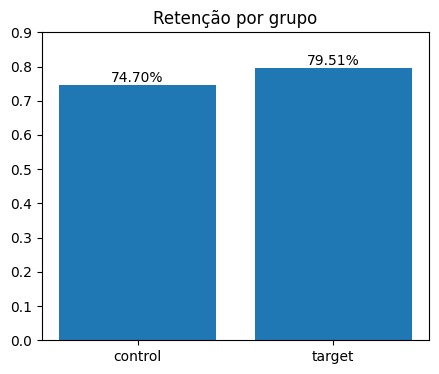

In [7]:
plt.figure(figsize=(5, 4))
plt.bar(df_gb_retencao.index, df_gb_retencao.values)
plt.title("Retenção por grupo")

plt.ylim([0, 0.9])


for i, value in enumerate(df_gb_retencao.values):
  plt.text(i, value, f'{value:.2%}', ha='center', va='bottom')

### A proporção dos targets é 40% maior do que o publico de controle

In [8]:
df_proporcao_target = df_pedidos_ab_teste["is_target"].value_counts(normalize=True) * 100
df_proporcao_target

,proportion
is_target,
target,58.440525
control,41.559475


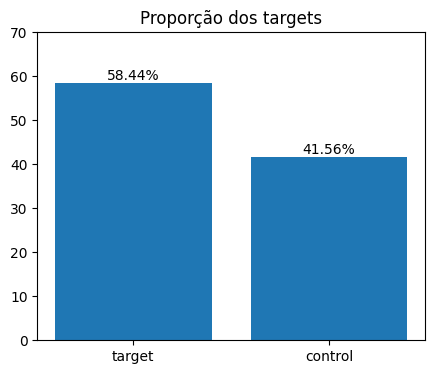

In [9]:
plt.figure(figsize=(5, 4))
plt.title("Proporção dos targets")
plt.ylim([0, 70])
plt.bar(df_proporcao_target.index, df_proporcao_target.values)
for i, value in enumerate(df_proporcao_target.values):
    plt.text(i, value, f'{value/100:.2%}', ha='center', va='bottom')

## Avaliando os outliers

In [10]:
# Estatísticas por grupo (incluindo percentis)
print(df_pedidos_ab_teste.groupby('is_target')['order_total_amount'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]))

               count       mean         std  min    25%   50%   75%     95%  \
is_target                                                                     
control    1525576.0  47.897891  165.052170  0.0  26.99  39.9  57.3  107.96   
target     2145250.0  47.901594   71.649248  0.0  26.90  39.9  57.4  108.70   

             99%       max  
is_target                   
control    175.0  138750.9  
target     178.0   57200.0  


A base tem muitos outliers -  que presisamos expurgar

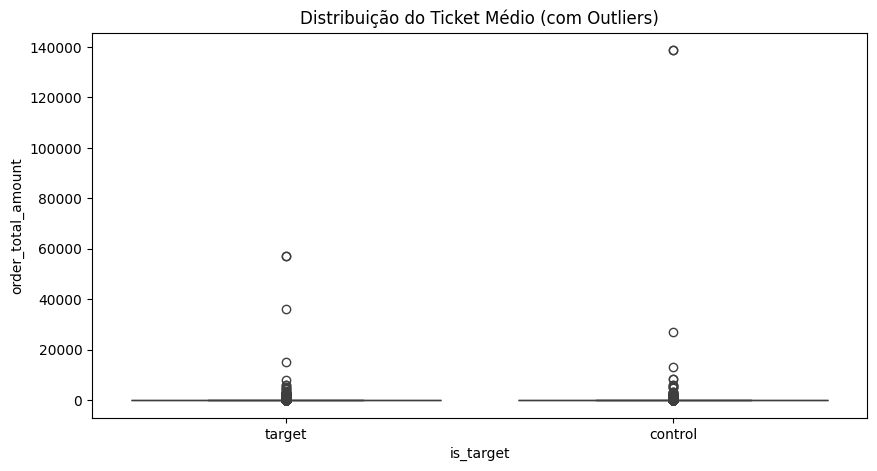

In [20]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_pedidos_ab_teste, x='is_target', y='order_total_amount')
plt.title('Distribuição do Ticket Médio (com Outliers)')
plt.show()

Visualização do boxplot sem os outliers

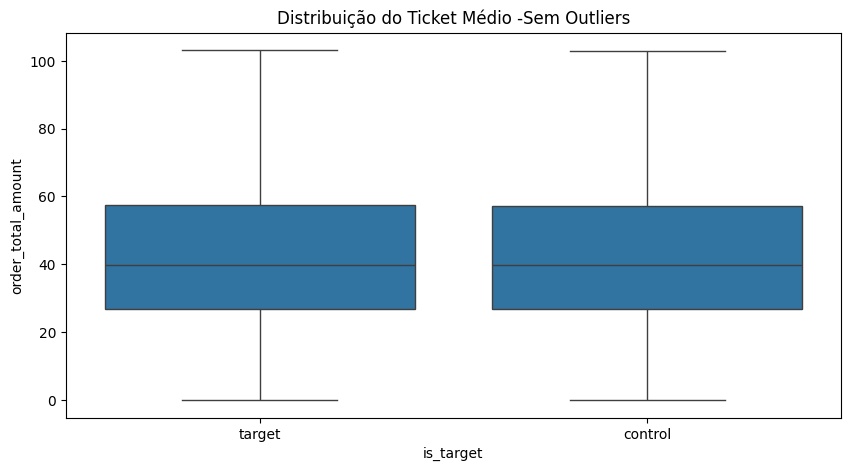

In [22]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_pedidos_ab_teste, x='is_target', y='order_total_amount', showfliers=False)
plt.title('Distribuição do Ticket Médio -Sem Outliers')
plt.show()

## Ticket Médio dos grupos

In [13]:
df_teste_hipotese = df_pedidos_ab_teste[['is_target','order_total_amount']].copy()

In [14]:
# Extrai os valores como arrays NumPy (já aplicando dropna())
gp_target = df_teste_hipotese.loc[df_teste_hipotese['is_target'] == 'target','order_total_amount'].dropna().to_numpy(dtype='float32')

gp_controle = df_teste_hipotese.loc[df_teste_hipotese['is_target'] == 'control','order_total_amount'].dropna().to_numpy(dtype='float32')


In [15]:
# Teste de hipotese entre os grupos
t_stat, p_value = ttest_ind(gp_target, gp_controle, method=None)

print(f"""
📊 Resultado do Teste T:
- Estatística T = {t_stat:.4f}
- P-value = {p_value:.10f}  # Notação científica se necessário
""")


📊 Resultado do Teste T:
- Estatística T = 0.0291
- P-value = 0.9767571898  # Notação científica se necessário



Diferença minima entre os grupos, P-value alto mostra que não há evidencia estastistica suficiente para para afirmar impacto, pode ser acaso

In [16]:
# Define o tamanho da amostra (ex: 10% de cada grupo)
sample_size = 0.1  # Ajuste conforme necessário

# Amostra aleatória do grupo_target
idx_target = np.random.choice(len(gp_target), size=int(len(gp_target) * sample_size), replace=False)
amostra_target = gp_target[idx_target]

# Amostra aleatória do grupo_controle
idx_controle = np.random.choice(len(gp_controle),size=int(len(gp_controle) * sample_size), replace=False)

amostra_controle = gp_controle[idx_controle]